# Monitor: 

- Loss
- pearson correlation
- prediction R2 (=prediction performace)

In [41]:
import pandas as pd
import numpy as np
import pickle 
import torch
from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace
from data.prepareData import prepareDataLoader_fromPkl
import matplotlib.pyplot as plt
#import seaborn as sns
import os

#from tensorflow.python.summary.summary_iterator import summary_iterator

# Load Data

In [51]:
PATH_data = "data"
PATH_results = "logs"

with open(os.path.join(PATH_data, "chr5_smoking_train.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = torch.tensor(train_dataset["beta"].values, dtype=torch.float32)

with open(os.path.join(PATH_data, "chr5_smoking_test.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Inspect one Model

In [43]:
name = f"smoking_chr5/latSize_200"
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# Run on test data
with torch.no_grad():
    recon = model(test_tensor).detach().numpy()
    latSpace = model.generate_embedding(test_tensor)

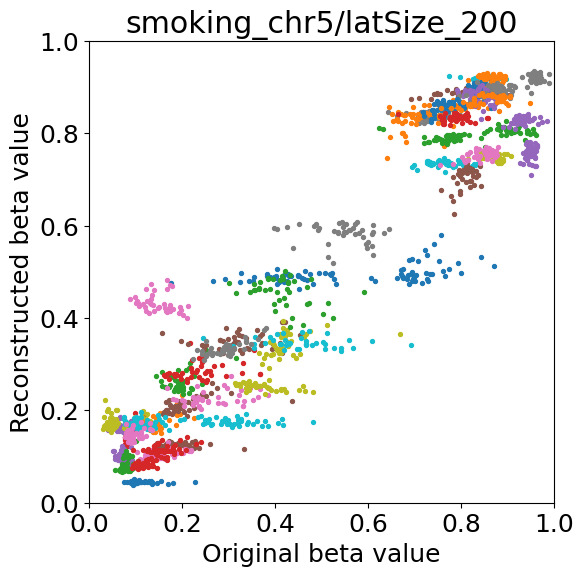

In [53]:
plot_cpg_reconstruction(model, test_tensor, title=name)

# All in one pipeline

In [56]:
def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return pearson

In [58]:
names = ["smoking_chr5/latSize_25", 
         "smoking_chr5/latSize_50", 
         "smoking_chr5/latSize_50_3hidden", 
         "smoking_chr5/latSize_200"] 
         
names_short = [ele.split("/")[1] for ele in names]

df_pearson = pd.DataFrame()
lst_r2 = []
for name in names:
    print(name)
    model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)

    # Get Pearson
    df_pearson[name] = getPearsonR(orig=test_tensor, recon=recon)
#     # Get supervised prediction (regression)
#     lst_r2.append(getRegression(name, latSpace, test_dataset))
# df_r2 = pd.DataFrame(lst_r2, index=names).T

smoking_chr5/latSize_25
smoking_chr5/latSize_50
smoking_chr5/latSize_50_3hidden
smoking_chr5/latSize_200


Text(0.5, 1.0, 'Reconstruction accuracy - Pearson R')

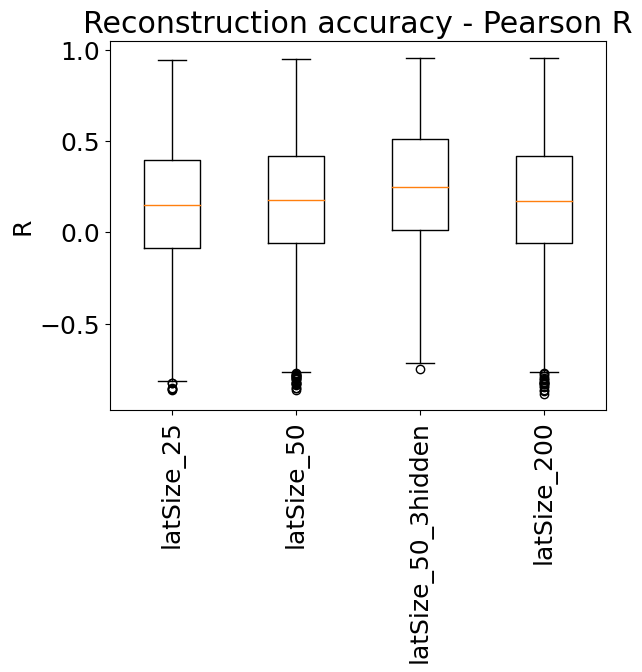

In [64]:
fig, ax = plt.subplots()
ax.boxplot(df_pearson)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("R")
ax.set_title("Reconstruction accuracy - Pearson R")